Import libraries and set directory

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from lib.solar_emphemeris import *
from chaosmagpy.data_utils import timestamp, mjd2000
from hp30client import getKpindex

C:\Users\klara\AppData\Local\Temp\ipykernel_11128\1667216064.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Define Paths and Files to read
DST_PATH = "Disturbance_Indices/Dst_MJD_1998.dat"
DATA_PATH = "Data/"

# Load dark data and store in data frame
dark_data = pd.read_table("ex2_dataset_only_dark.txt", delimiter=",")

# Load in Dst indices:
time_Dst, Dst = np.loadtxt(DST_PATH, usecols=(0,1), comments='#',unpack=True)

# Put into pandas dataframe for easy access
Dst_indices = pd.DataFrame({'time_Dst': time_Dst, 'Dst': Dst})

# Get Hp30 indices
startdate_whole = timestamp(dark_data['time_stamp'].iloc[0])
enddate_whole = timestamp(dark_data['time_stamp'].iloc[-1])
startdate = np.datetime64(startdate_whole, 'D') # ensure correct length
enddate = np.datetime64(enddate_whole, 'D')
time_Hp30, Hp30, _ = getKpindex(str(startdate), str(enddate), 'Hp30')

# Convert times to mjd2000
stamp = []
for i in np.arange(0, len(time_Hp30)):
    yr1, mn1, dt1 = time_Hp30[i].split("-")
    hr1, min1, _ = time_Hp30[i].split(":")
    stamp.append(to_mjd2000(int(yr1), int(mn1), int(dt1[:2]), int(hr1[-2:]), int(min1)))

In [3]:

Hp30_indices = pd.DataFrame({'time_Hp30': stamp, 'Hp30': Hp30})

Investigate Hp30 data

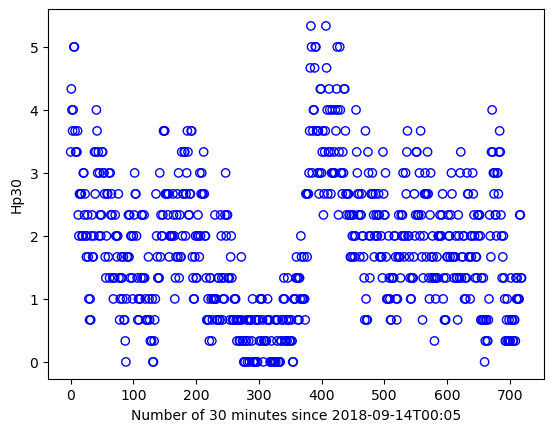

In [4]:
since = np.arange(0, len(Hp30_indices))

plt.scatter(since, Hp30, facecolor = 'None', edgecolor = 'blue')
plt.xlabel('Number of 30 minutes since ' + str(np.datetime64(startdate_whole, 'm')))
plt.ylabel('Hp30')
plt.show()

In [30]:
# Kp10 to compare distribution
time_Kp, Kp = np.loadtxt("Disturbance_Indices/Kp_MJD_1998_QL.dat", usecols=(0,1), comments='#',unpack=True)
Kp_indices = pd.DataFrame({'time_Kp': time_Kp, 'Kp': Kp})

Kpinterp = np.interp(Hp30_indices.time_Hp30.values, Kp_indices.time_Kp.values, Kp_indices.Kp.values);

c:\Users\klara\anaconda3\envs\bachelors\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\klara\anaconda3\envs\bachelors\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Frequency distribution of Kp10 indices sep 2018')

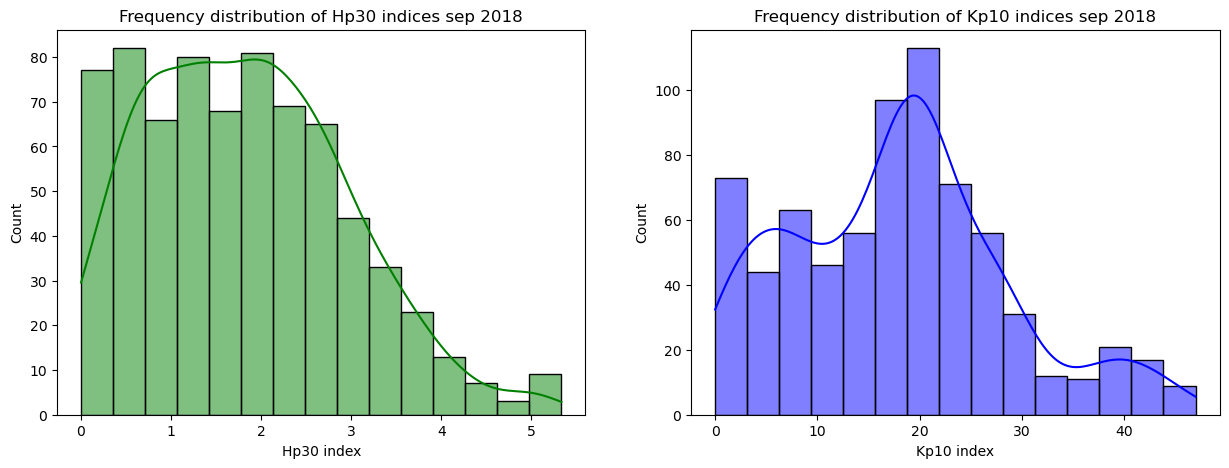

In [40]:
import seaborn as sns 
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(Hp30, color='green', kde=True, ax=axs[0])
axs[0].set_xlabel('Hp30 index')
axs[0].set_title('Frequency distribution of Hp30 indices sep 2018')

sns.histplot(Kpinterp, color='blue', kde=True, ax=axs[1])
axs[1].set_xlabel('Kp10 index')
axs[1].set_title('Frequency distribution of Kp10 indices sep 2018')




Quiet-time selection

In [42]:
# Compute hourly Dst differences
Dst_indices['Dst_Hourly_Difference'] = Dst_indices.Dst.diff();

# Interpolate differences and store them in data frame
dark_data['dDst'] = np.abs(np.interp(dark_data.time_stamp.values, Dst_indices.time_Dst.values, Dst_indices.Dst_Hourly_Difference.values));

In [43]:
dark_data['Hp30'] = np.interp(dark_data.time_stamp.values, Hp30_indices.time_Hp30.values, Hp30_indices.Hp30.values);

In [50]:
# Extract data, which is not quiet
dataframe = dark_data.query('Hp30 <= 3.5 & dDst <= 3');

# print("After removal of sunlit and noisy data " + str(len(dataframe)) + " data points remain")
print("Compared to the number of Kp10-dark-and-quiet-filtered data " + str(10114) + ", removal of datapoints with Hp30 <= 3.5 results in " + str(len(dataframe) - 10114) + " more data points")

Compared to the number of Kp10-dark-and-quiet-filtered data 10114, removal of datapoints with Hp30 <= 3.5 results in 201 more data points
